In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib widget

In [2]:
df = pd.read_csv("archive/Amazon_Unlocked_Mobile.csv")
df

,Product Name,Brand Name,Price,Rating,Reviews,Review Votes
0,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,5,I feel so LUCKY to have found this used (phone...,1.0
1,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,"nice phone, nice up grade from my pantach revu...",0.0
2,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,5,Very pleased,0.0
3,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,It works good but it goes slow sometimes but i...,0.0
4,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,Great phone to replace my lost phone. The only...,0.0
...,...,...,...,...,...,...
413835,Samsung Convoy U640 Phone for Verizon Wireless...,Samsung,79.95,5,another great deal great price,0.0
413836,Samsung Convoy U640 Phone for Verizon Wireless...,Samsung,79.95,3,Ok,0.0
413837,Samsung Convoy U640 Phone for Verizon Wireless...,Samsung,79.95,5,Passes every drop test onto porcelain tile!,0.0
413838,Samsung Convoy U640 Phone for Verizon Wireless...,Samsung,79.95,3,I returned it because it did not meet my needs...,0.0


In [3]:
from transformers import AutoTokenizer, AutoModel
import torch

def get_sentence_embedding(sentence, model, tokenizer):
    # Tokenize input sentence
    tokens = tokenizer(sentence, return_tensors="pt")

    # Get the transformer model output
    with torch.no_grad():
        outputs = model(**tokens)

    # Extract the output embeddings (CLS token)
    embeddings = outputs.last_hidden_state[:, 0, :]

    return embeddings.numpy()

# Load pre-trained model and tokenizer
model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

# Example sentence
example_sentence = "prajjwal1/tinybert-base"

# Get sentence embedding
sentence_embedding = get_sentence_embedding(example_sentence, model, tokenizer)

# Convert to numpy array for easier handling
sentence_embedding_np = sentence_embedding

print(sentence_embedding_np)


[[-3.14555198e-01 -1.29714653e-01 -8.12298506e-02 -1.02534473e-01
   9.84638557e-03  5.87203503e-02  2.14219108e-01  1.81473032e-01
  -3.62780318e-02 -1.68450087e-01 -5.50031438e-02 -1.57682717e-01
  -1.01264812e-01  1.54709309e-01  5.72968051e-02  3.34332496e-01
  -2.03298807e-01  1.42534003e-01  1.73580304e-01 -1.00338738e-02
  -5.52621037e-02 -4.03049022e-01 -1.12609416e-01 -1.87535331e-01
  -9.32240188e-02  1.40794799e-01  1.55620635e-01 -3.79411429e-02
   1.07291445e-01  5.21790348e-02 -2.39131898e-01  1.13351583e-01
  -5.35255000e-02 -1.50900260e-01  2.54729033e-01 -4.45207246e-02
   2.27340143e-02 -2.78615594e-01  1.44556910e-01 -1.68371052e-02
   2.83454987e-03 -1.85281008e-01  1.15628153e-01  4.52040210e-02
  -9.10846666e-02  1.72066823e-01 -2.23935127e+00  2.39019077e-02
  -2.80723661e-01 -1.93219990e-01  5.79180531e-02  6.40443563e-02
   2.32982822e-02  4.93287265e-01  2.98041403e-01  1.88149750e-01
  -6.85792416e-03  1.81621894e-01  3.14592302e-01  7.59335384e-02
  -9.14318

In [4]:
counts = df["Product Name"].value_counts().reset_index()
subset = df[df["Product Name"] == counts.iloc[1500]["Product Name"]]
subset['Rating'] = subset['Rating'].astype(str)
subset["embedding"] = subset["Rating"].apply(get_sentence_embedding, args = (model, tokenizer))
subset

/tmp/ipykernel_19333/3728159422.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['Rating'] = subset['Rating'].astype(str)
/tmp/ipykernel_19333/3728159422.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset["embedding"] = subset["Rating"].apply(get_sentence_embedding, args = (model, tokenizer))


,Product Name,Brand Name,Price,Rating,Reviews,Review Votes,embedding
206584,IRULU Universe 1s (U1s) Phone 5 Inch 3G Unlock...,iRULU,150.0,5,bueno,0.0,"[[-0.14396961, -0.17481193, 0.1087572, -0.1391..."
206585,IRULU Universe 1s (U1s) Phone 5 Inch 3G Unlock...,iRULU,150.0,1,Worst phone,0.0,"[[-0.24045807, -0.13956533, 0.0965412, -0.1156..."
206586,IRULU Universe 1s (U1s) Phone 5 Inch 3G Unlock...,iRULU,150.0,5,Good,0.0,"[[-0.14396961, -0.17481193, 0.1087572, -0.1391..."
206587,IRULU Universe 1s (U1s) Phone 5 Inch 3G Unlock...,iRULU,150.0,5,Iit's a nice runing phone,0.0,"[[-0.14396961, -0.17481193, 0.1087572, -0.1391..."
206588,IRULU Universe 1s (U1s) Phone 5 Inch 3G Unlock...,iRULU,150.0,4,I purchased this phone for my little sister. I...,0.0,"[[-0.26267016, -0.09101184, 0.077594586, -0.15..."
206589,IRULU Universe 1s (U1s) Phone 5 Inch 3G Unlock...,iRULU,150.0,4,Really surprised by this phone. I have had it ...,0.0,"[[-0.26267016, -0.09101184, 0.077594586, -0.15..."
206590,IRULU Universe 1s (U1s) Phone 5 Inch 3G Unlock...,iRULU,150.0,4,This phone was very good to me and I had it fo...,0.0,"[[-0.26267016, -0.09101184, 0.077594586, -0.15..."
206591,IRULU Universe 1s (U1s) Phone 5 Inch 3G Unlock...,iRULU,150.0,2,Mobile is good looking and has many features. ...,0.0,"[[-0.31391314, -0.082546964, 0.18049543, -0.12..."
206592,IRULU Universe 1s (U1s) Phone 5 Inch 3G Unlock...,iRULU,150.0,5,My mother loves her phone,0.0,"[[-0.14396961, -0.17481193, 0.1087572, -0.1391..."
206593,IRULU Universe 1s (U1s) Phone 5 Inch 3G Unlock...,iRULU,150.0,1,After 10 months it's now not turning on.,0.0,"[[-0.24045807, -0.13956533, 0.0965412, -0.1156..."


In [5]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
embed = np.vstack(subset["embedding"].to_numpy())
project = pca.fit_transform(embed)

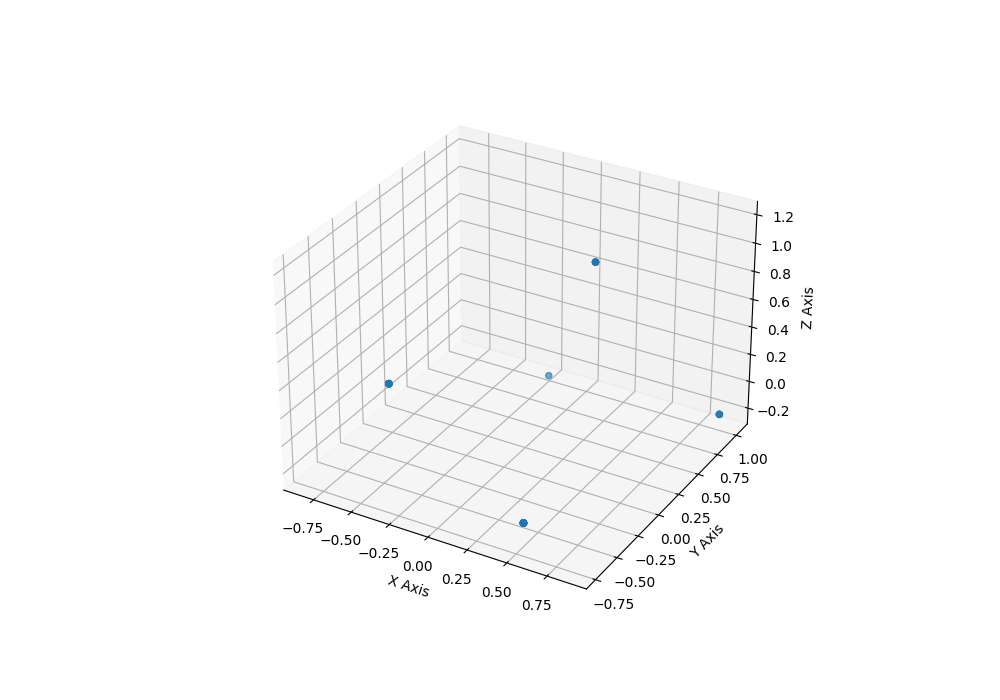

In [6]:
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")
ax.set_xlabel('X Axis')
ax.set_ylabel('Y Axis')
ax.set_zlabel('Z Axis')
ax.scatter3D(project[:,0], project[:,1], project[:,2])

In [7]:
print("hi")

hi


In [8]:
project

array([[-0.8271329 ,  0.09764664, -0.03351958],
       [ 0.8679373 ,  1.023714  , -0.21610986],
       [-0.8271328 ,  0.0976466 , -0.0335197 ],
       [-0.8271328 ,  0.0976466 , -0.03351955],
       [ 0.53260523, -0.7259672 , -0.09985247],
       [ 0.53260523, -0.7259672 , -0.09985247],
       [ 0.53260523, -0.7259672 , -0.09985247],
       [ 0.19981755,  0.16311122,  0.32621616],
       [-0.8271328 ,  0.0976466 , -0.03351955],
       [ 0.8679373 ,  1.0237142 , -0.2161099 ],
       [ 0.47008252,  0.19457069,  1.1902887 ],
       [ 0.8679373 ,  1.0237142 , -0.2161099 ],
       [ 0.53260523, -0.7259672 , -0.09985247],
       [-0.8271328 ,  0.0976466 , -0.03351955],
       [ 0.8679373 ,  1.0237142 , -0.2161099 ],
       [ 0.53260523, -0.7259672 , -0.09985247],
       [ 0.47008252,  0.19457069,  1.1902887 ],
       [-0.8271328 ,  0.0976466 , -0.03351955],
       [ 0.53260523, -0.7259672 , -0.09985247],
       [-0.8271328 ,  0.0976466 , -0.03351955],
       [-0.8271328 ,  0.0976466 , -0.033